<a href="https://colab.research.google.com/github/MiracleCakra/Machine-Learning_Ganjil_2025/blob/main/Week10_JS09_KLASIFIKASI/Tugas1_KLASIFIKASI_kNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  klasifikasi dengan menggunakan kNN

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

import warnings
warnings.filterwarnings("ignore")

# (Colab) upload file
try:
    from google.colab import files
    print("Silakan upload file voice.csv ...")
    up = files.upload()  # pilih voice.csv
    CSV_PATH = [k for k in up.keys() if k.lower().endswith(".csv")][0]
except Exception as e:
    # Jika run di environment lain, sesuaikan path manual
    CSV_PATH = "voice.csv"
    print(f"Menetapkan CSV_PATH default: {CSV_PATH}. Pastikan file ada di path ini.")

Silakan upload file voice.csv ...


Saving voice.csv to voice.csv


## Load Data

In [5]:
df = pd.read_csv(CSV_PATH)
df.columns = [c.strip() for c in df.columns]

# Deteksi target
target_candidates = [c for c in df.columns if c.lower() in ("label", "gender", "class")]
if not target_candidates:
    # fallback: ambil kolom object terakhir
    obj_cols = df.select_dtypes(include=["object"]).columns.tolist()
    if not obj_cols:
        raise ValueError("Tidak menemukan kolom target (mis. 'label'). Mohon pastikan voice.csv memiliki kolom label/gender.")
    target_col = obj_cols[-1]
else:
    target_col = target_candidates[0]

# X, y
y = df[target_col].astype(str).str.lower().str.strip()
X = df.drop(columns=[target_col]).select_dtypes(include=[np.number]).copy()
X = X.fillna(X.median())

print(f"Target column: {target_col}")
print("Distribusi kelas:")
print(y.value_counts(), "\n")

display(df.head())

Target column: label
Distribusi kelas:
label
male      1584
female    1584
Name: count, dtype: int64 



,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


## Frekuensi suara pria dan wanita

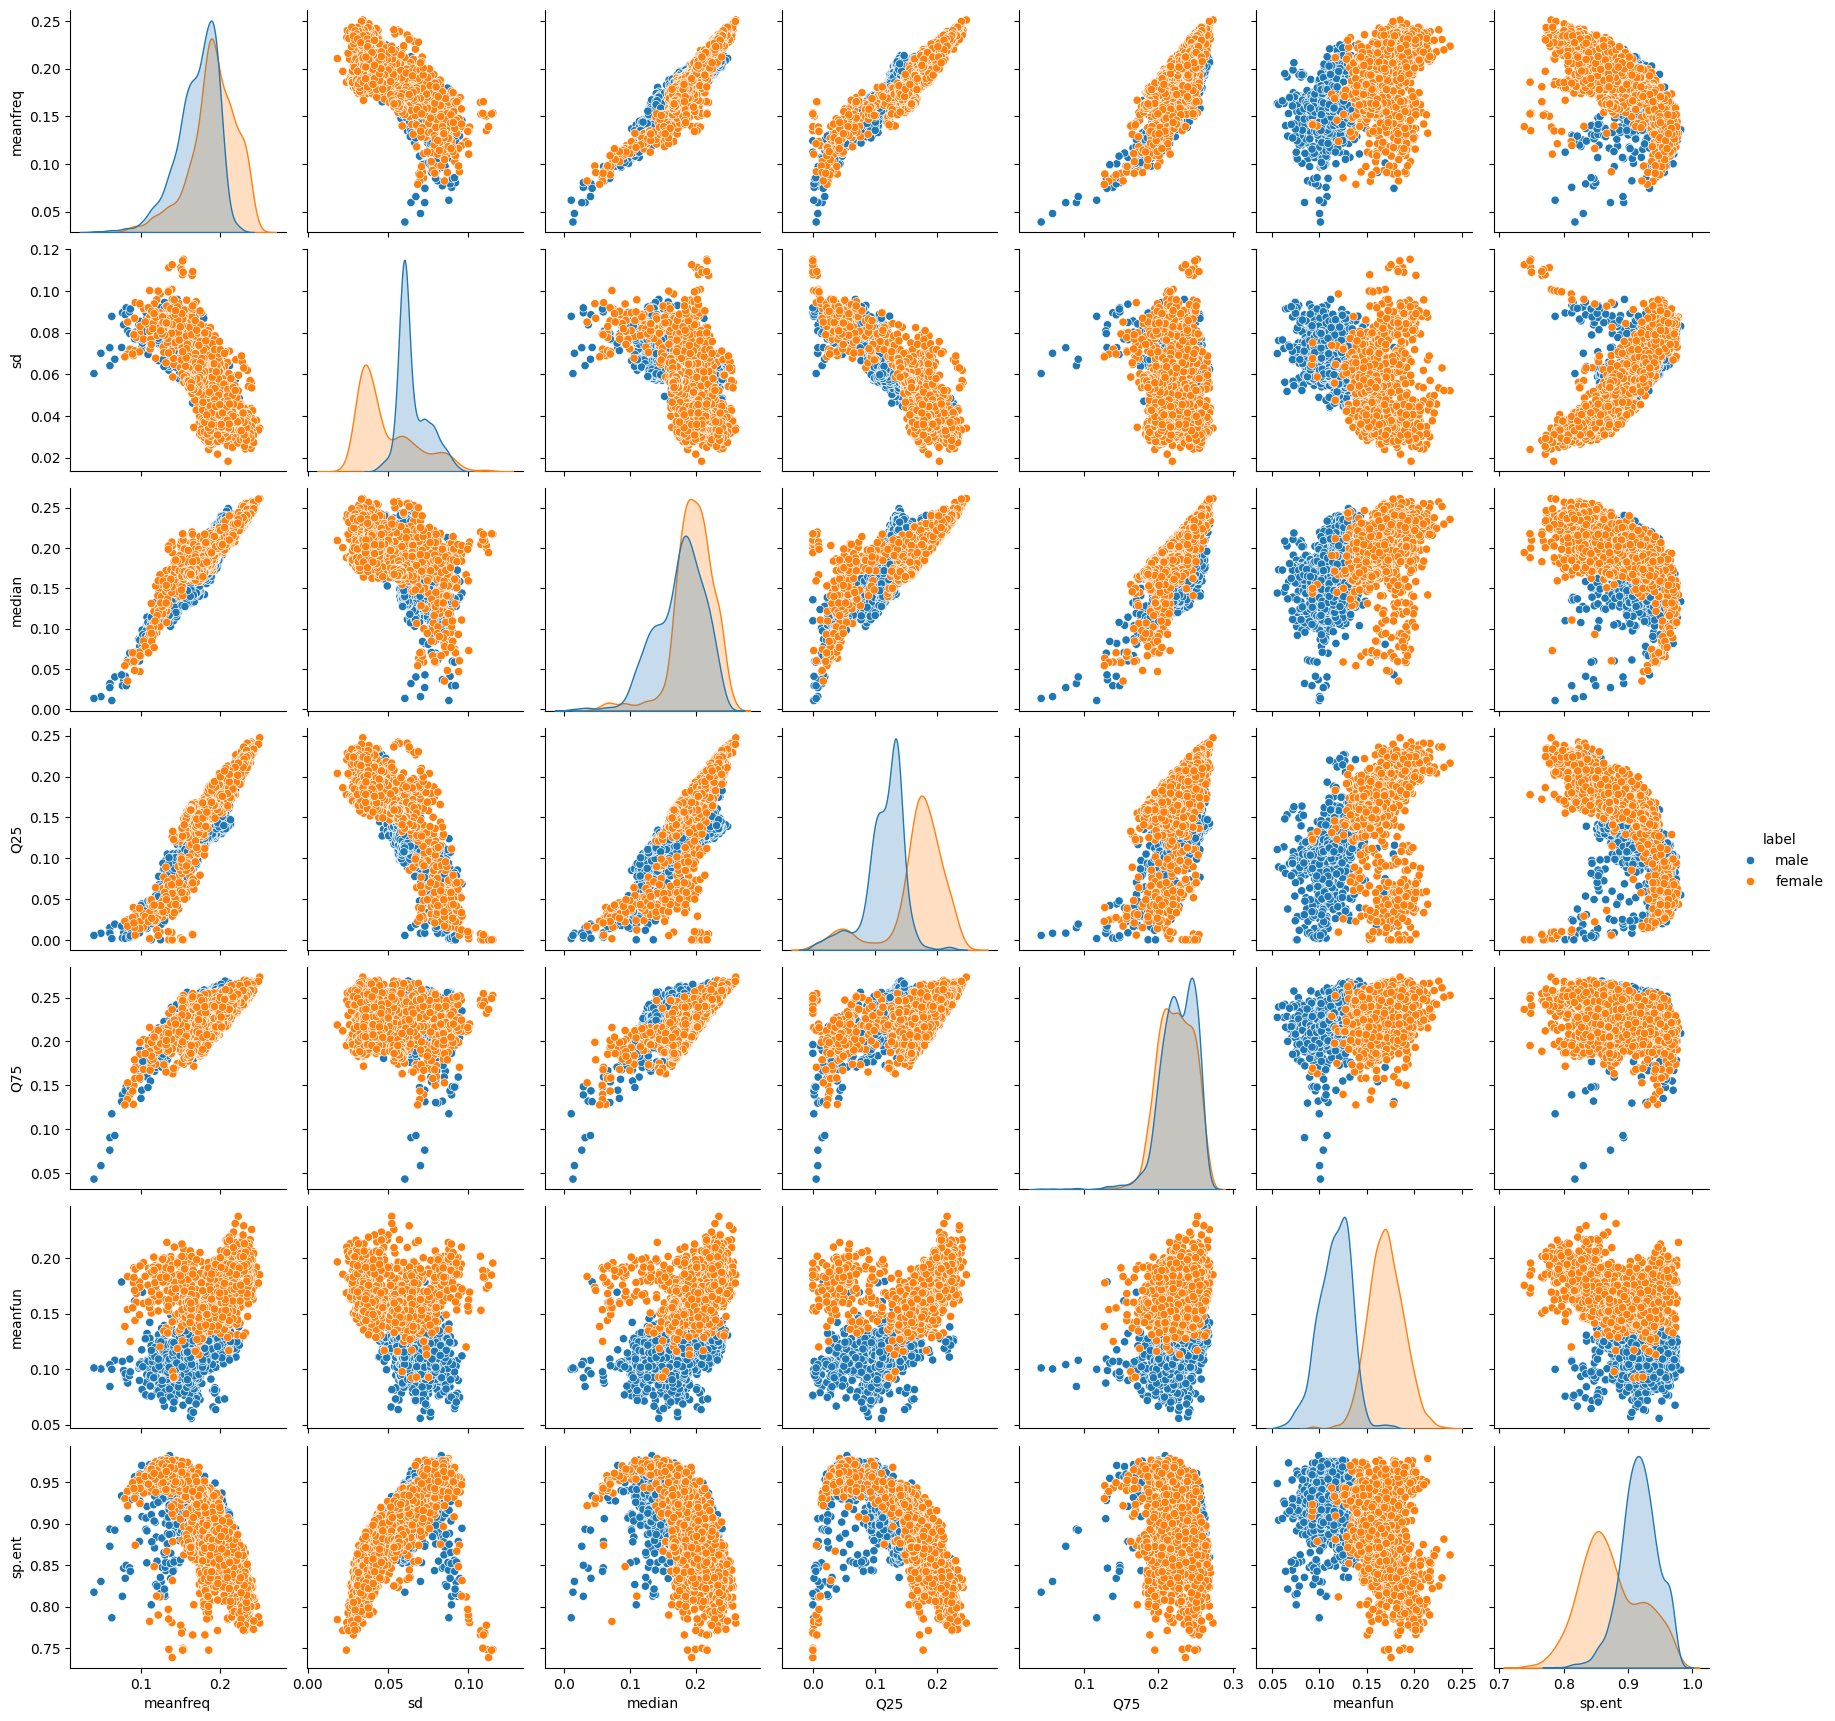

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df[['meanfreq', 'sd', 'median', 'Q25', 'Q75', 'meanfun', 'sp.ent', 'label']], hue='label')
plt.show()

## Melakukan pembagian data Train dan data Test

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (2534, 20), Test shape: (634, 20)


## Baseline kNN (semua fitur) - CV berbagai nilai k


=== Baseline (Semua fitur) — Top-5 k berdasarkan CV Accuracy ===


,k,cv_acc_mean,cv_acc_std,cv_f1_macro_mean,cv_f1_macro_std
1,3,0.973953,0.005212,0.973949,0.005214
3,7,0.971188,0.006579,0.971185,0.006578
2,5,0.969609,0.008628,0.969606,0.008626
0,1,0.968032,0.004592,0.968030,0.004591
4,9,0.962898,0.009322,0.962893,0.009323


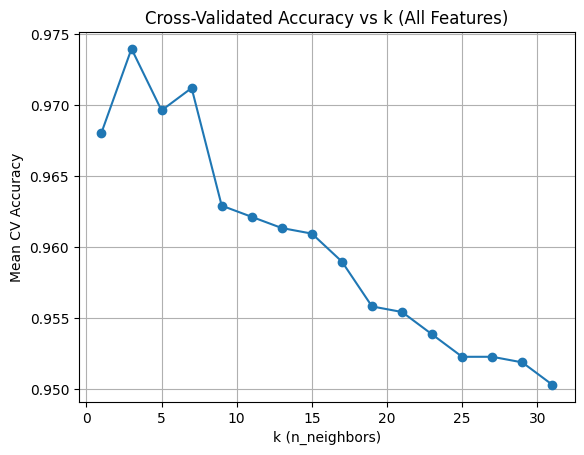

In [7]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
k_values = list(range(1, 32, 2))  # 1..31 ganjil

baseline_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

cv_rows = []
for k in k_values:
    baseline_pipe.set_params(knn__n_neighbors=k)
    acc = cross_val_score(baseline_pipe, X_train, y_train, cv=cv, scoring="accuracy", n_jobs=-1)
    f1m = cross_val_score(baseline_pipe, X_train, y_train, cv=cv, scoring="f1_macro", n_jobs=-1)
    cv_rows.append({
        "k": k,
        "cv_acc_mean": acc.mean(),
        "cv_acc_std": acc.std(),
        "cv_f1_macro_mean": f1m.mean(),
        "cv_f1_macro_std": f1m.std(),
    })

cv_full = pd.DataFrame(cv_rows).sort_values("cv_acc_mean", ascending=False)
print("\n=== Baseline (Semua fitur) — Top-5 k berdasarkan CV Accuracy ===")
display(cv_full.head(5))

# Grafik: Akurasi CV vs k (semua fitur)
plt.figure()
plt.plot([r["k"] for r in cv_rows], [r["cv_acc_mean"] for r in cv_rows], marker="o")
plt.title("Cross-Validated Accuracy vs k (All Features)")
plt.xlabel("k (n_neighbors)")
plt.ylabel("Mean CV Accuracy")
plt.grid(True)
plt.show()

## Perbandingan Akurasi data Train dan data Test

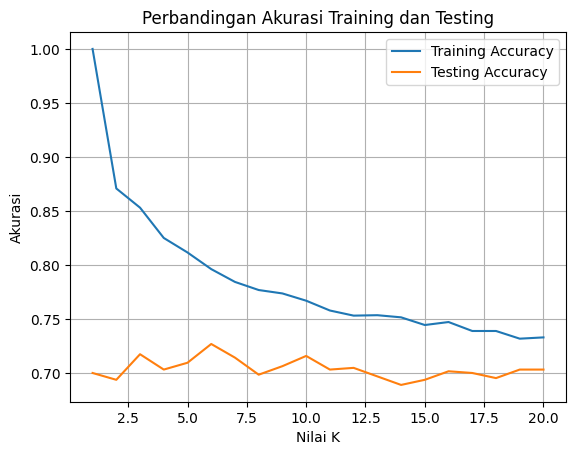

In [15]:
training_acc = []
testing_acc = []
neighbors = range(1, 21)

for n in neighbors:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    training_acc.append(knn.score(X_train, y_train))
    testing_acc.append(knn.score(X_test, y_test))

plt.plot(neighbors, training_acc, label='Training Accuracy')
plt.plot(neighbors, testing_acc, label='Testing Accuracy')
plt.xlabel('Nilai K')
plt.ylabel('Akurasi')
plt.title('Perbandingan Akurasi Training dan Testing')
plt.legend()
plt.grid(True)
plt.show()

##  Feature Selection + Grid Search (SelectKBest + kNN).
dengan menggunakan Dua metode: ANOVA F-test dan Mutual Information


=== TOP-10 ANOVA F-test (berdasarkan CV Accuracy) ===


,rank,cv_acc_mean,cv_acc_std,n_features,k_neighbors
33,1,0.979080,0.005685,7,3
65,2,0.978687,0.005217,12,3
34,3,0.977898,0.003175,7,5
18,4,0.977505,0.003667,5,5
35,5,0.977502,0.005401,7,7
17,6,0.977109,0.004267,5,3
36,7,0.976714,0.004229,7,9
49,8,0.976713,0.005927,9,3
81,9,0.976321,0.002797,15,3
50,10,0.976320,0.005994,9,5



=== TOP-10 Mutual Information (berdasarkan CV Accuracy) ===


,rank,cv_acc_mean,cv_acc_std,n_features,k_neighbors
64,1,0.979872,0.005357,12,1
50,2,0.979081,0.005680,9,5
34,3,0.977899,0.003167,7,5
33,4,0.977109,0.003885,7,3
81,5,0.976714,0.007840,15,3
65,6,0.976713,0.006309,12,3
17,7,0.975926,0.003835,5,3
48,8,0.975924,0.006307,9,1
49,9,0.975528,0.007144,9,3
52,10,0.975136,0.005940,9,9


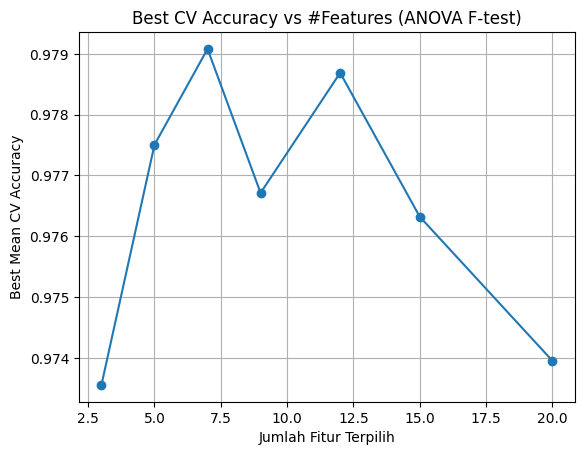

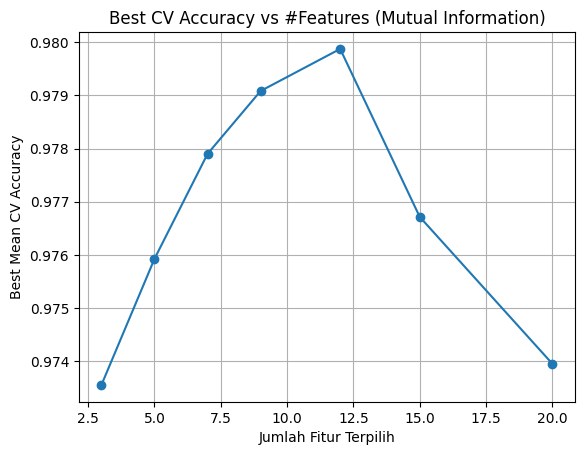


=== Konfigurasi Terbaik (CV) ===
Selector : Mutual Information
#Fitur   : 12
k        : 1

Fitur Terpilih (Best):
 1. meanfreq
 2. sd
 3. median
 4. Q25
 5. IQR
 6. sp.ent
 7. sfm
 8. mode
 9. centroid
10. meanfun
11. mindom
12. maxdom


In [10]:
def gridsearch_kbest(score_func, score_name):
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("kbest", SelectKBest(score_func=score_func)),
        ("knn", KNeighborsClassifier())
    ])

    max_kfeat = min(20, X_train.shape[1])  # batasi agar cepat
    kfeat_candidates = sorted(set([3, 5, 7, 9, 12, 15, max_kfeat]))
    kfeat_candidates = [k for k in kfeat_candidates if k <= X_train.shape[1]]

    param_grid = {
        "kbest__k": kfeat_candidates,
        "knn__n_neighbors": k_values
    }

    gs = GridSearchCV(
        pipe, param_grid,
        cv=cv, scoring="accuracy",
        n_jobs=-1, refit=True, return_train_score=False
    )
    gs.fit(X_train, y_train)

    res = pd.DataFrame(gs.cv_results_)
    res["selector"] = score_name

    best_pipe = gs.best_estimator_
    mask = best_pipe.named_steps["kbest"].get_support()
    selected = X_train.columns[mask].tolist()

    return gs, res, selected

gs_f, res_f, sel_f = gridsearch_kbest(f_classif, "ANOVA F-test")
gs_mi, res_mi, sel_mi = gridsearch_kbest(mutual_info_classif, "Mutual Information")

def summarize_top(res_df, name):
    keep = res_df[[
        "rank_test_score", "mean_test_score", "std_test_score",
        "param_kbest__k", "param_knn__n_neighbors"
    ]].sort_values("rank_test_score").head(10)
    keep.columns = ["rank", "cv_acc_mean", "cv_acc_std", "n_features", "k_neighbors"]
    print(f"\n=== TOP-10 {name} (berdasarkan CV Accuracy) ===")
    display(keep)

summarize_top(res_f, "ANOVA F-test")
summarize_top(res_mi, "Mutual Information")

def plot_best_by_kfeat(res_df, title):
    tmp = (res_df[["param_kbest__k", "mean_test_score"]]
           .groupby("param_kbest__k")["mean_test_score"].max()
           .reset_index()
           .sort_values("param_kbest__k"))
    plt.figure()
    plt.plot(tmp["param_kbest__k"], tmp["mean_test_score"], marker="o")
    plt.title(title)
    plt.xlabel("Jumlah Fitur Terpilih")
    plt.ylabel("Best Mean CV Accuracy")
    plt.grid(True)
    plt.show()
    return tmp

best_curve_f = plot_best_by_kfeat(res_f, "Best CV Accuracy vs #Features (ANOVA F-test)")
best_curve_mi = plot_best_by_kfeat(res_mi, "Best CV Accuracy vs #Features (Mutual Information)")

# Pilih overall terbaik (antara ANOVA & MI) berdasarkan mean_test_score
all_res = pd.concat([
    res_f.assign(selector="ANOVA F-test"),
    res_mi.assign(selector="Mutual Information")
], ignore_index=True)

best_idx = all_res["mean_test_score"].idxmax()
best_row = all_res.loc[best_idx]

best_selector = best_row["selector"]
best_kfeat = int(best_row["param_kbest__k"])
best_k = int(best_row["param_knn__n_neighbors"])

print("\n=== Konfigurasi Terbaik (CV) ===")
print(f"Selector : {best_selector}")
print(f"#Fitur   : {best_kfeat}")
print(f"k        : {best_k}")

# Rekonstruksi pipeline terbaik untuk mengekstrak fitur tepatnya
score_func = f_classif if best_selector == "ANOVA F-test" else mutual_info_classif
best_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("kbest", SelectKBest(score_func=score_func, k=best_kfeat)),
    ("knn", KNeighborsClassifier(n_neighbors=best_k))
])
best_pipe.fit(X_train, y_train)
mask = best_pipe.named_steps["kbest"].get_support()
best_features = X_train.columns[mask].tolist()

print("\nFitur Terpilih (Best):")
for i, f in enumerate(best_features, 1):
    print(f"{i:>2}. {f}")

## Final Fit dan Evaluation on Test Set


=== Evaluasi Test Set (dengan fitur & k terbaik) ===
Accuracy   : 0.9811
F1-macro   : 0.9811

Classification report:
              precision    recall  f1-score   support

      female     0.9841    0.9779    0.9810       317
        male     0.9781    0.9842    0.9811       317

    accuracy                         0.9811       634
   macro avg     0.9811    0.9811    0.9811       634
weighted avg     0.9811    0.9811    0.9811       634



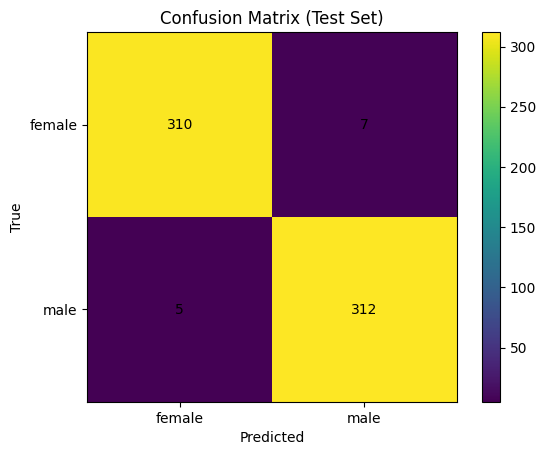

In [11]:
y_pred = best_pipe.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
test_f1m = f1_score(y_test, y_pred, average="macro")

print("\n=== Evaluasi Test Set (dengan fitur & k terbaik) ===")
print(f"Accuracy   : {test_acc:.4f}")
print(f"F1-macro   : {test_f1m:.4f}\n")
print("Classification report:")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix (plot)
labels_sorted = np.sort(y.unique())
cm = confusion_matrix(y_test, y_pred, labels=labels_sorted)

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=range(len(labels_sorted)), labels=labels_sorted)
plt.yticks(ticks=range(len(labels_sorted)), labels=labels_sorted)
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.colorbar()
plt.show()

In [26]:
print("### Analisa Hasil Klasifikasi kNN ###")

print("\n1. Model Klasifikasi kNN:")
print("Model klasifikasi menggunakan algoritma k-Nearest Neighbors (kNN) untuk membedakan antara suara 'male' dan 'female' berdasarkan dataset voice.csv.")
print("Proses ini melibatkan beberapa tahapan, termasuk memuat data, membaginya menjadi data latih (train) dan data uji (test), melakukan scaling fitur, memilih fitur terbaik, menyetel hyperparameter (nilai k), dan mengevaluasi performa model.")

print("\n2. Fitur Optimal:")
print("Untuk menemukan fitur yang paling optimal, disini melakukan perbandingan dua metode pemilihan fitur:")
print("- ANOVA F-test: Mengukur ketergantungan linear antara fitur dan target.")
print("- Mutual Information: Mengukur ketergantungan non-linear dan linear antara fitur dan target.")
print(f"Model terbaik didapatkan dengan menggunakan fitur yang dipilih oleh metode {best_selector}.")
print(f"Jumlah fitur terbaik yang dipilih adalah {best_kfeat} fitur.")
print("Fitur-fitur terpilih adalah:")
for i, f in enumerate(best_features, 1):
    print(f"- {f}")

print(f"akurasi CV tertinggi berubah dengan jumlah fitur yang berbeda pada grafik 'Best CV Accuracy vs #Features ({best_selector})'.")


print("\n3. Nilai k (n_neighbors) Terbaik:")
print(f"Setelah fitur-fitur terbaik dipilih, disini saya menggunakan Grid Search lagi untuk mencari nilai *k* (jumlah tetangga terdekat) yang paling optimal.")
print(f"Nilai k terbaik yang ditemukan melalui Grid Search dengan fitur terpilih dari {best_selector} adalah {best_k}.")
print("Alasan memilih nilai k ini adalah karena konfigurasi dengan k=1 dan 12 fitur (menggunakan Mutual Information) memberikan akurasi CV rata-rata tertinggi sebesar 0.9799, seperti yang terlihat pada hasil 'TOP-10 Mutual Information (berdasarkan CV Accuracy)'.")
print("Dapat dilihat juga bagaimana akurasi CV bervariasi terhadap nilai k pada grafik 'Cross-Validated Accuracy vs k (All Features)' (menggunakan semua fitur sebagai baseline) dan tabel hasil TOP-10 dari Grid Search.")

print("\n4. Hasil Akhir pada Test Set:")
print(f"Setelah menemukan konfigurasi terbaik (selector: {best_selector}, #fitur: {best_kfeat}, k: {best_k}), model dievaluasi pada data uji (test set) yang belum pernah dilihat sebelumnya.")
print("Hasil evaluasi pada test set adalah:")
print(f"- Accuracy: {test_acc:.4f}")
print(f"- F1-macro: {test_f1m:.4f}")

### Analisa Hasil Klasifikasi kNN ###

1. Model Klasifikasi kNN:
Model klasifikasi menggunakan algoritma k-Nearest Neighbors (kNN) untuk membedakan antara suara 'male' dan 'female' berdasarkan dataset voice.csv.
Proses ini melibatkan beberapa tahapan, termasuk memuat data, membaginya menjadi data latih (train) dan data uji (test), melakukan scaling fitur, memilih fitur terbaik, menyetel hyperparameter (nilai k), dan mengevaluasi performa model.

2. Fitur Optimal:
Untuk menemukan fitur yang paling optimal, disini melakukan perbandingan dua metode pemilihan fitur:
- ANOVA F-test: Mengukur ketergantungan linear antara fitur dan target.
- Mutual Information: Mengukur ketergantungan non-linear dan linear antara fitur dan target.
Model terbaik didapatkan dengan menggunakan fitur yang dipilih oleh metode Mutual Information.
Jumlah fitur terbaik yang dipilih adalah 12 fitur.
Fitur-fitur terpilih adalah:
- meanfreq
- sd
- median
- Q25
- IQR
- sp.ent
- sfm
- mode
- centroid
- meanfun
- mindom
- 